### Data description
● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
 
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
dic = pd.read_json('ultimate_data_challenge.json')
df = pd.DataFrame.from_dict(dic, orient= 'columns')
print(df.shape)
df.head()

(50000, 12)


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## Review the dataset

In [3]:
#see a summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [4]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [5]:
import pandas_profiling

#Create profiling report
report = df.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)

#Save report to file
report.to_file(output_file= "usage_report.html")

### Findings from profiling report:
* #### There are 8 duplicate rows,
* #### users signed up from 3 different cities,
* #### There are 8719 missing cells, while 8112 of missing cells are in avg_rating_of_driver column,
* #### Distribution of avg_rating_of_driver is a right-skewed,
* #### avg_surge has a left-skewed distribution (mean and median at left),
* #### Most of last_trip_date were on Jun-29, then on Jun-28 and Jun-29 respectively,
* #### More than 2 out of 3 users used iPhone,
* #### surge_pct distribution is quite left-skewed distribution, mostly with zero value,
* #### Less than 50% of users took Ultimate Black,
* #### Majority of users tripped only during the weekday(Mon-Fri) or only on weekend,
* #### avg_dist has a quite left-skewed distribution, majority less than 25 miles,
* #### avg_rating_by_driver has a right-skewed distribution with 201 missing values,
* #### surge_pct and avg_surge are highly positively correlated.


In [6]:
df = df.drop_duplicates()
df.shape

(49992, 12)

## Filling missing values

* ### phone

In [7]:
round(df.phone.value_counts(normalize= True, dropna= False),3)

iPhone     0.692
Android    0.300
NaN        0.008
Name: phone, dtype: float64

**69% of users' device is iPhone. Let's fill missing values (less than 0.1%) with iPhone.**

In [8]:
df.phone = df.phone.fillna(value= 'iPhone')
df.phone.isna().sum()

0

* ### avg_rating_of_driver

In [9]:
round(df.avg_rating_of_driver.value_counts(normalize= True, dropna= False).head(3),3)

5.0    0.415
NaN    0.162
4.0    0.084
Name: avg_rating_of_driver, dtype: float64

**41% of avg rating of drivers is 5, and 33% of avg rating is equal or less than 4. Mean is 4.3 and median 4.9. let's fill the missing values with mean.**

In [10]:
df.avg_rating_of_driver.fillna(round(df.avg_rating_of_driver.mean(),2), inplace= True)
df.avg_rating_of_driver.isna().sum()

0

* ### avg_rating_by_driver

In [11]:
round(df.avg_rating_by_driver.value_counts(normalize= True, dropna= False).head(12),3)

5.0    0.570
4.8    0.091
4.7    0.067
4.9    0.062
4.5    0.048
4.6    0.042
4.0    0.038
4.3    0.020
4.4    0.017
3.0    0.012
4.2    0.007
NaN    0.004
Name: avg_rating_by_driver, dtype: float64

In [12]:
df.avg_rating_by_driver.fillna(round(df.avg_rating_by_driver.mean(),2), inplace= True)
df.avg_rating_by_driver.isna().sum()

0

In [13]:
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

## Exploration

* ## Is the dataset balanced?

In [14]:
#convert type of date columns from object to datetime
df['signup_date'] = df['signup_date'].apply(lambda x : pd.to_datetime(x))
df['last_trip_date'] = df['last_trip_date'].apply(lambda x : pd.to_datetime(x))

In [15]:
df.signup_date.min(), df.signup_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-01-31 00:00:00'))

**sign up date are between 31 days in Jan 2014 (not a leap year).**

In [16]:
df.last_trip_date.min(), df.last_trip_date.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

**users tripped from Jan firse until July first in 2014.**

In [17]:
import datetime
start_interval = df.last_trip_date.max() - datetime.timedelta(days=30)
end_interval = df.last_trip_date.max()

df['active'] = ((df.last_trip_date >= start_interval) & (start_interval <= end_interval )).astype(int)
active_pct = df['active'].value_counts(normalize= True, dropna= False).round(2)
active_pct = pd.DataFrame(active_pct).reset_index()
active_pct.columns = ['status','percentage']
active_pct.status.replace({0: 'Inactive', 1:'Active'},inplace= True)
active_pct

,status,percentage
0,Inactive,0.62
1,Active,0.38


### only 38% users were active in the preceding 30 days, which means only 38% of customers retained.


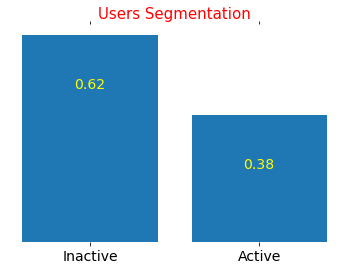

In [18]:
bars = plt.bar(x= active_pct.status, height= active_pct.percentage)
for spine in plt.gca().spines.values():
    spine.set_visible (False)

plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')

#direct label each bar with Y axis values
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-0.16,
                   bar.get_height().round(2), ha='center', color='yellow', fontsize=14)
    
    
plt.xticks(fontsize=14)    
plt.title('Users Segmentation',fontsize=15, c='red')
plt.show()

### Dataset is imbalance

In [19]:
df.city.value_counts(normalize= True, dropna= False).round(2)

Winterfell        0.47
Astapor           0.33
King's Landing    0.20
Name: city, dtype: float64

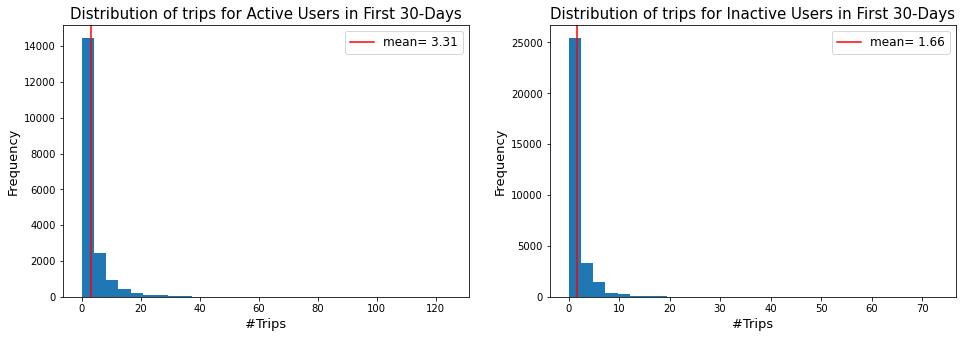

In [20]:
#active
active_first_month = df.loc[df.active == 1, 'trips_in_first_30_days']
active_first_month_mean = round(active_first_month.mean(), 2)

#inactive
inactive_first_month = df.loc[df.active == 0, 'trips_in_first_30_days']
inactive_first_month_mean = round(inactive_first_month.mean(), 2)


plt.figure(figsize=(16,5))
ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

ax1.hist(active_first_month, bins= 30)
ax1.axvline(active_first_month_mean, label= 'mean= {}'.format(active_first_month_mean), c='red')
ax1.set_title('Distribution of trips for Active Users in First 30-Days', fontsize=15)
ax1.set_xlabel('#Trips', fontsize= 13)
ax1.set_ylabel('Frequency', fontsize= 13)
ax1.legend(fontsize=12)

ax2.hist(inactive_first_month, bins= 30)
ax2.axvline(inactive_first_month_mean, label= 'mean= {}'.format(inactive_first_month_mean), c='red')
ax2.set_title('Distribution of trips for Inactive Users in First 30-Days', fontsize=15)
ax2.set_xlabel('#Trips', fontsize= 13)
ax2.set_ylabel('Frequency', fontsize= 13)
ax2.legend(fontsize=12)

plt.show()

### Active users had 3 trips on average in the first 30-days, while inactive users had on average 1 trip.

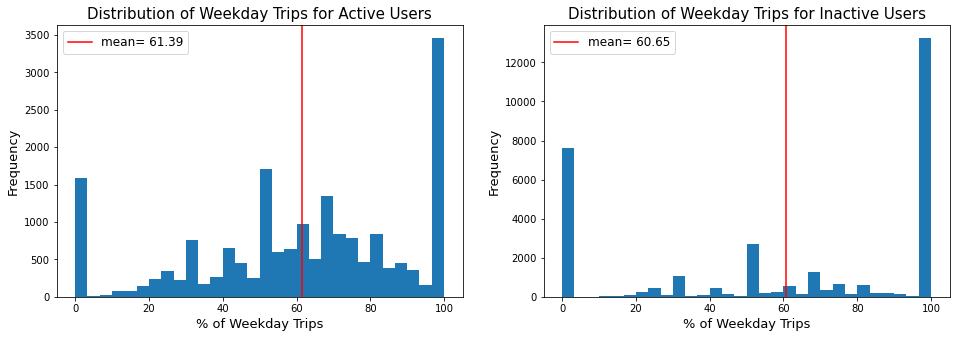

In [21]:
#inactive
inactive_weekday = df.loc[df.active == 0, 'weekday_pct']
inactive_weekday_mean = round(inactive_weekday.mean(), 2)

#active
active_weekday = df.loc[df.active == 1, 'weekday_pct']
active_weekday_mean = round(active_weekday.mean(), 2)


plt.figure(figsize=(16,5))
ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

ax1.hist(active_weekday, bins= 30)
ax1.axvline(active_weekday_mean, label= 'mean= {}'.format(active_weekday_mean), c='red')
ax1.set_title('Distribution of Weekday Trips for Active Users', fontsize=15)
ax1.set_xlabel('% of Weekday Trips', fontsize= 13)
ax1.set_ylabel('Frequency', fontsize= 13)
ax1.legend(fontsize=12)


ax2.hist(inactive_weekday, bins= 30)
ax2.axvline(inactive_weekday_mean, label= 'mean= {}'.format(inactive_weekday_mean), c='red')
ax2.set_title('Distribution of Weekday Trips for Inactive Users', fontsize=15)
ax2.set_xlabel('% of Weekday Trips', fontsize= 13)
ax2.set_ylabel('Frequency', fontsize= 13)
ax2.legend(fontsize=12)

plt.show()

* ### Majority of active users took weekday rides,
* ### Majority of inactive users took only weekday or weekend rides,
* ### Frequency of weekday and weekend rides taken by inactive users are significantly higher than active users,

In [22]:
#active
users = df.groupby(['active','city'])['city'].count()
users = pd.DataFrame(users)
users.rename(columns= {'city': '#users'}, inplace= True)
users.reset_index(inplace= True)
users.rename(columns= {'active': 'status'}, inplace= True)
users['status'].replace({0: 'Inactive', 1: 'Active'}, inplace= True)
users = pd.pivot_table(users, index= ['status'], columns = ['city'], values= ['#users'])
users.columns = ['#users_Astapor', '#users_KingsLanding', '#users_Winterfell']
users

,#users_Astapor,#users_KingsLanding,#users_Winterfell
status,,,
Active,4228,6363,8213
Inactive,12303,3767,15118


In [23]:
n_inactives = users.loc['Inactive'].sum()
n_actives = users.loc['Active'].sum()
n = n_inactives + n_actives


users.loc['Inactive'] = round(users.loc['Inactive']/n, 2)
users.loc['Active'] = round(users.loc['Active']/n, 2)

users.columns = ['%users_Astapor', '%users_KingsLanding', '%users_Winterfell']

users = users.T
users

status,Active,Inactive
%users_Astapor,0.08,0.25
%users_KingsLanding,0.13,0.08
%users_Winterfell,0.16,0.30


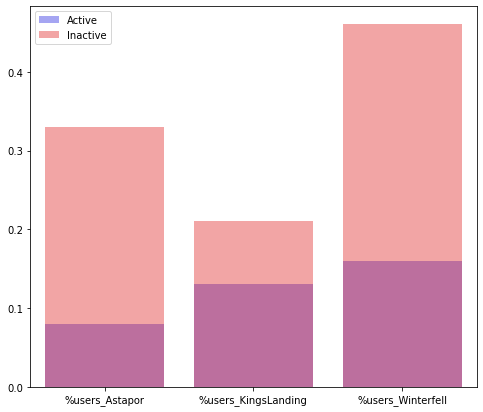

In [24]:
import seaborn as sns
ax = plt.subplots(figsize=(8,7))
ax= sns.barplot(x= users.index, y= users.Active, alpha=0.4, label= 'Active',color= 'b')
ax= sns.barplot(x= users.index, y= users.Active + users.Inactive,  alpha=0.4, label= 'Inactive', color='r')

plt.ylabel('')
plt.legend()
plt.show()

* ### Winterfell has highest percentage of active and inactive users,
* ### Astapor has less than 10% active users,
* ### King's Landing has less than 10% inactive users.

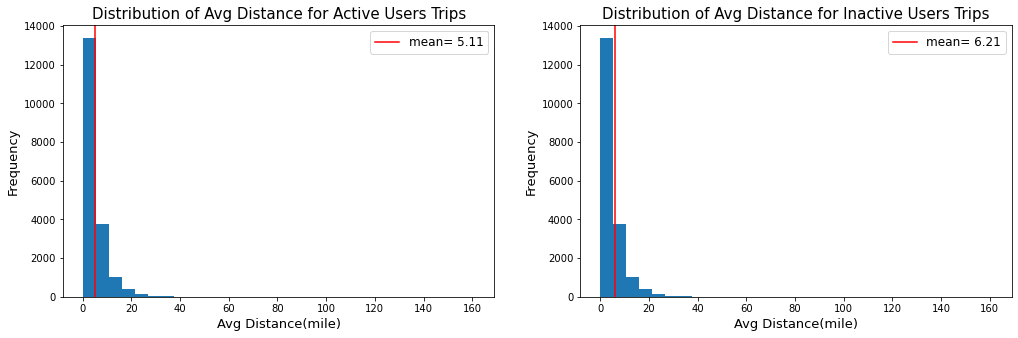

In [25]:
#active
active_avg_dist = df.loc[df.active == 1, 'avg_dist']
active_avg_dist_mean = round(active_avg_dist.mean(),2)


#inactive
inactive_avg_dist = df.loc[df.active == 0, 'avg_dist']
inactive_avg_dist_mean = round(inactive_avg_dist.mean(),2)


plt.figure(figsize=(17,5))
ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

ax1.hist(active_avg_dist, bins= 30)
ax1.axvline(active_avg_dist_mean, label= 'mean= {}'.format(active_avg_dist_mean), c='red')
ax1.set_title('Distribution of Avg Distance for Active Users Trips', fontsize=15)
ax1.set_xlabel('Avg Distance(mile)', fontsize= 13)
ax1.set_ylabel('Frequency', fontsize= 13)
ax1.legend(fontsize=12)


ax2.hist(active_avg_dist, bins= 30)
ax2.axvline(inactive_avg_dist_mean, label= 'mean= {}'.format(inactive_avg_dist_mean), c='red')
ax2.set_title('Distribution of Avg Distance for Inactive Users Trips', fontsize=15)
ax2.set_xlabel('Avg Distance(mile)', fontsize= 13)
ax2.set_ylabel('Frequency', fontsize= 13)
ax2.legend(fontsize=12)

plt.show()

In [26]:
print('std avg_dist of active users= ', round(active_avg_dist.std(),2), 'mile')
print('std avg_dist of inactive users= ', round(inactive_avg_dist.std(),2), 'mile')

std avg_dist of active users=  4.62 mile
std avg_dist of inactive users=  6.24 mile


### On average active users triped 1.10 mile less than active, with 1.62 mile less standard deviation.

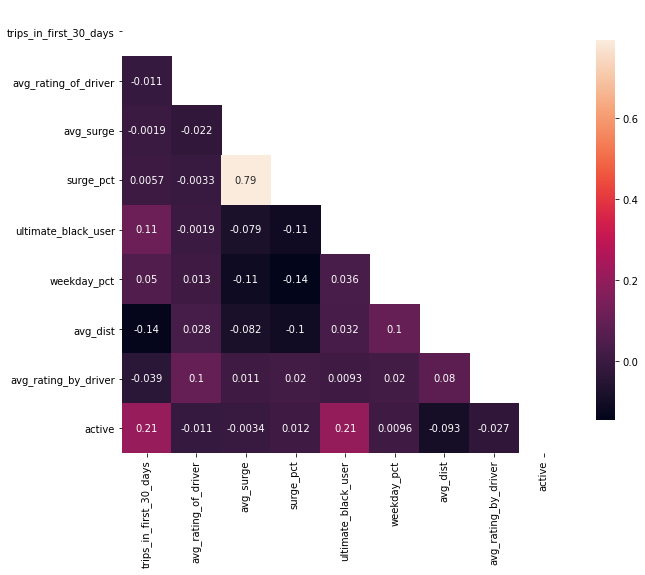

In [27]:
plt.figure(figsize=(10,10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(),square=True, annot=True, mask=mask, cbar_kws={"shrink": .7})

plt.show()

**the pandas profiling showed that avg_surge and surge_pct are highly positively correlated.**

## Modeling

### Encoding categorical predictors

In [28]:
categorical_columns = df.select_dtypes(include= ['object'], exclude= ['datetime']).columns
categorical_columns

Index(['city', 'phone'], dtype='object')

In [29]:
df = pd.get_dummies(df , categorical_columns)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0


In [30]:
df = df.drop(['signup_date', 'last_trip_date'], axis= 1)
df.columns = ['trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active',
       'city_Astapor', 'city_KingsLanding', 'city_Winterfell',
       'phone_Android', 'phone_iPhone']

### Methods to deal with an  imbalance dataset

### Classifier Performance Metrics
Active class is underpresented and inactive class is overpresented. If two class size was 50/50 then dataset would be balanced.
Training model on an imbalanced data will result into inaccurate performance metrics such as precision, recall, accuracy and f-score. 

Model performance metrics for each class are:

**Precision:** means if I randomly pick an active user, what is the probability of making right prediction about the user?

**Recall:** means if a user is predicted as an active user, what is the probability that the user be active in reallity?

**F-score:** is an harmonic mean of Precision and Recall, (2×precision×recall / (precision + recall))

In this specific problem it is important that the model predicts active customrs for marketing purposes, in other words, a model that **reduces the False Negative** as many as possible. **I am looking for a model that optimizes the recall score.**


**ROC:**
* **T:** is threshold which difines the decision rule, it ranges from 1 to 0,
* **p(active | user1):** probability of a given user (user1) being active,
* **if p(active| user1) >= T** then user1 belongs to active class, so each value of T can generate a point (FP,TP), 

**ROC curve is the curve described by the ensemble of points generated when T varies from 1 to 0.**

**AUC:** the Area Under the ROC curve tends towards 1.0 for the best case and towards 0.5 for the worst case.

**A good AUC score:** means that the model we are evaluating **does not sacrifice a lot of precision to get a good recall** on the observed class (often the minority class).

These methods are often presented as **great ways** to balance the dataset before fitting a classifier on it. In a few words, these methods act on the dataset as follows:

* **undersampling:** consists in sampling from the majority class in order to keep only a part of these points
* **oversampling:** consists in replicating some points from the minority class in order to increase its cardinality
* **Generating synthetic data:** consists in creating new synthetic points from the minority class (see SMOTE method for example) to increase its cardinality

https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

In [31]:
df_minority = df[df.active == 1]
df_majority = df[df.active == 0]

In [32]:
split_idx = int(0.75 * len(df))
train_set =  df[:split_idx ]
test_set = df[split_idx: ]

print('train_set shape:', train_set.shape)
print('test_set shape:', test_set.shape)

train_set shape: (37494, 14)
test_set shape: (12498, 14)


In [33]:
from sklearn.utils import resample


#Resample df of minority class
df_minority_resample = resample(df_minority, n_samples = 10000, replace = True, random_state= 42)
train_set_oversampled = pd.concat([train_set , df_minority_resample])

X_Train_oversampled = train_set_oversampled.drop('active', axis= 1).values
y_Train_oversampled = train_set_oversampled['active'].values


print('X_Train_oversampled shape', X_Train_oversampled.shape)
print('y_Train_oversampled shape', y_Train_oversampled.shape)

X_Train_oversampled shape (47494, 13)
y_Train_oversampled shape (47494,)


In [34]:
X_Test = test_set.drop('active', axis=1).values
y_Test = test_set['active'].values

print('X_Test shape', X_Test.shape)
print('y_Test shape', y_Test.shape)

X_Test shape (12498, 13)
y_Test shape (12498,)


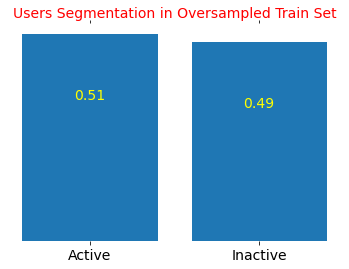

In [35]:
active_oversampled = train_set_oversampled['active'].value_counts(normalize= True, dropna= False).round(2)
active_oversampled = pd.DataFrame(active_oversampled).reset_index()
active_oversampled.columns = ['status','percentage']
active_oversampled.status.replace({0: 'Inactive', 1:'Active'},inplace= True)
active_oversampled

bars = plt.bar(x= active_oversampled.status, height= active_oversampled.percentage)
for spine in plt.gca().spines.values():
    spine.set_visible (False)

plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')

#direct label each bar with Y axis values
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-0.16,
                   bar.get_height().round(2), ha='center', color='yellow', fontsize=14)
    
    
plt.xticks(fontsize=14)    
plt.title('Users Segmentation in Oversampled Train Set',fontsize=14, c='red')
plt.show()

### Now the oversampled train set is balanced, I can use it for modeling.

### Individual Model

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

results = pd.DataFrame(columns= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

* ### Ridge Classifier

In [37]:
from sklearn.linear_model import RidgeClassifierCV


ridge_clf = RidgeClassifierCV()
ridge_clf.fit(X_Train_oversampled , y_Train_oversampled)
ridge_pred = ridge_clf.predict(X_Test)


results = results.append(pd.Series(['Ridge Classifier']+
                                  [round(accuracy_score(y_Test, ridge_pred),2),
                                  round(precision_score(y_Test, ridge_pred),2),
                                  round(recall_score(y_Test, ridge_pred),2),
                                  round(f1_score(y_Test, ridge_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

* ### Logistic Regression

In [38]:
%%time
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_Train_oversampled , y_Train_oversampled)
log_pred = log_reg.predict(X_Test)


results = results.append(pd.Series(['LogisticRegression']+
                                  [round(accuracy_score(y_Test, log_pred),2),
                                  round(precision_score(y_Test, log_pred),2),
                                  round(recall_score(y_Test, log_pred),2),
                                  round(f1_score(y_Test, log_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

Wall time: 698 ms


* ### Support Vector Classification

In [39]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipeline = make_pipeline(StandardScaler() , SVC(gamma= 'auto'))
pipeline.fit(X_Train_oversampled, y_Train_oversampled)
svc_pred = pipeline.predict(X_Test)


results = results.append(pd.Series(['SVC']+
                                  [round(accuracy_score(y_Test, svc_pred),2),
                                  round(precision_score(y_Test, svc_pred),2),
                                  round(recall_score(y_Test, svc_pred),2),
                                  round(f1_score(y_Test, svc_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

Wall time: 1min 44s


### Ensemble Modeling (tree based)
Ensemble learning is very powerful for classification and regression problems.

* ### Adaptive Boost classifier

A meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [40]:
from sklearn.ensemble import AdaBoostClassifier

adb_clf = AdaBoostClassifier(n_estimators=100)
adb_clf.fit(X_Train_oversampled, y_Train_oversampled)
adb_pred = adb_clf.predict(X_Test)


results = results.append(pd.Series(['Adaptive Boost Classifier']+
                                  [round(accuracy_score(y_Test, adb_pred),2),
                                  round(precision_score(y_Test, adb_pred),2),
                                  round(recall_score(y_Test, adb_pred),2),
                                  round(f1_score(y_Test, adb_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

* ### Gradient Boosting for classification.

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=100)
gb_clf.fit(X_Train_oversampled, y_Train_oversampled)
gb_pred = gb_clf.predict(X_Test)


results = results.append(pd.Series(['Gradient Boosting Classifier']+
                                  [round(accuracy_score(y_Test, gb_pred),2),
                                  round(precision_score(y_Test, gb_pred),2),
                                  round(recall_score(y_Test, gb_pred),2),
                                  round(f1_score(y_Test, gb_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

* ### Random Forest Clossifier

A meta estimator that fits a number of decision tree classifiers on **various sub-samples** of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [42]:
from sklearn.ensemble import RandomForestClassifier



rf_clf = RandomForestClassifier(n_estimators=100,  #n_estimators: number of trees
                                max_features= 'auto', 
                                random_state= 42)
rf_clf.fit(X_Train_oversampled, y_Train_oversampled)
rf_pred = rf_clf.predict(X_Test)


results = results.append(pd.Series(['RandomForest Classifier']+
                                  [round(accuracy_score(y_Test, rf_pred),2),
                                  round(precision_score(y_Test, rf_pred),2),
                                  round(recall_score(y_Test, rf_pred),2),
                                  round(f1_score(y_Test, rf_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

In [43]:
from sklearn.model_selection import RandomizedSearchCV

# Create the grid space
param_grid = {'n_estimators': [100, 200, 300],
               'max_features': ['auto', 'sqrt'],       # Number of features to consider at every split
               'max_depth': [int(x) for x in np.linspace(10, 140, num = 14)],
               'bootstrap': [True, False]             # Method of selecting samples for training each tree
             }

randomized_rf_clf = RandomizedSearchCV(rf_clf, param_grid, cv=4)
randomized_rf_clf.fit(X_Train_oversampled, y_Train_oversampled)
randomized_rf_clf.best_params_

{'n_estimators': 300,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [44]:
best_rf_clf = RandomForestClassifier(n_estimators= 300, max_features= 'auto', max_depth= 20, bootstrap= True)

best_rf_clf.fit(X_Train_oversampled, y_Train_oversampled)
best_rf_clf_pred = best_rf_clf.predict(X_Test)


results = results.append(pd.Series(['Best RandomForest Classifier']+
                                  [round(accuracy_score(y_Test, best_rf_clf_pred),2),
                                  round(precision_score(y_Test, best_rf_clf_pred),2),
                                  round(recall_score(y_Test, best_rf_clf_pred),2),
                                  round(f1_score(y_Test, best_rf_clf_pred),2)],
                            index= ['model', 'Accuracy', 'Precision', 'Recall', 'F1-score']),
                            ignore_index= True)

In [45]:
results

,model,Accuracy,Precision,Recall,F1-score
0,Ridge Classifier,0.70,0.58,0.69,0.63
1,LogisticRegression,0.70,0.59,0.69,0.63
2,SVC,0.75,0.64,0.77,0.70
3,Adaptive Boost Classifier,0.78,0.67,0.78,0.72
4,Gradient Boosting Classifier,0.78,0.68,0.78,0.72
5,RandomForest Classifier,0.79,0.68,0.83,0.75
6,Best RandomForest Classifier,0.79,0.68,0.84,0.75


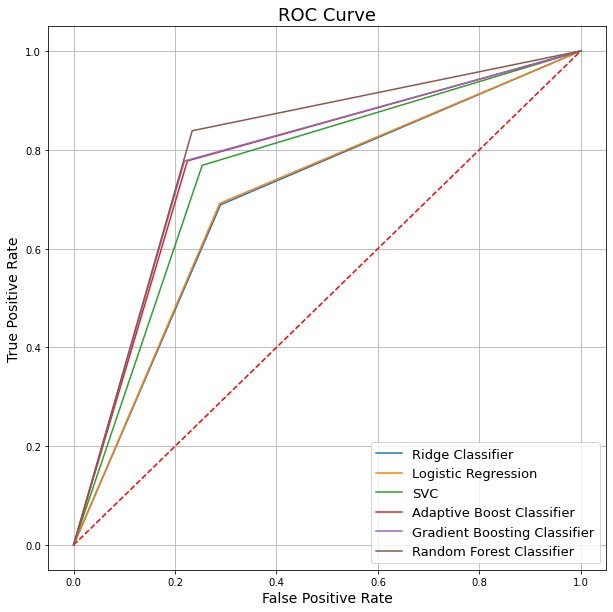

In [47]:
from sklearn.metrics import roc_curve, plot_roc_curve



fpr_ridge, tpr_ridge, thresholds_ridge = roc_curve(y_Test, ridge_pred)
fpr_log, tpr_log, thresholds_log = roc_curve(y_Test, log_pred)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_Test, svc_pred)
fpr_adb, tpr_adb, thresholds_adb = roc_curve(y_Test, adb_pred)
fpr_rgb, tpr_gb, thresholds_gb = roc_curve(y_Test, gb_pred)
fpr_best_rf, tpr_best_rf, thresholds_best_rf = roc_curve(y_Test, best_rf_clf_pred)


plt.figure(figsize= (10,10))
plt.plot([0,1], [0,1], 'r--' , )
plt.plot(fpr_ridge, tpr_ridge, label='Ridge Classifier')
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_svc, tpr_svc, label='SVC')
plt.plot(fpr_adb, tpr_adb, label='Adaptive Boost Classifier')
plt.plot(fpr_rgb, tpr_gb, label='Gradient Boosting Classifier')
plt.plot(fpr_best_rf, tpr_best_rf, label='Random Forest Classifier')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)
plt.grid(True)
plt.legend(fontsize=13)
plt.show()

### Plot feature importance

13


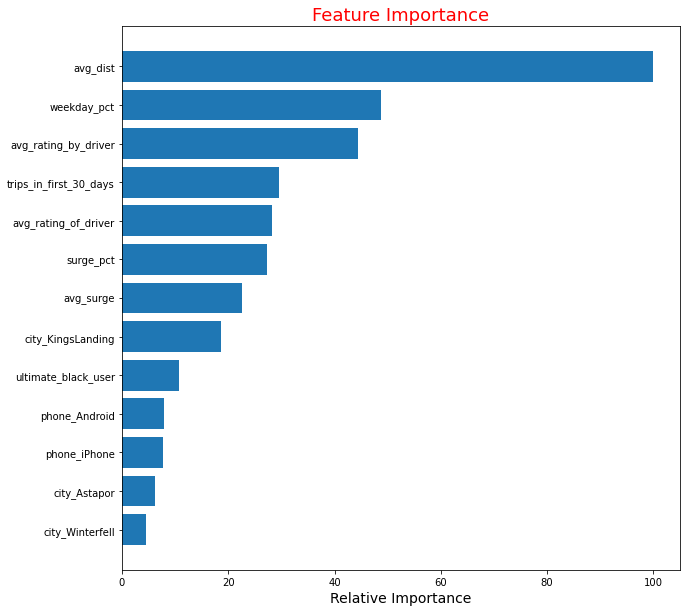

In [50]:
feature_importance = best_rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_set_oversampled.drop('active', axis= 1).columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize= 14)
plt.title('Feature Importance', fontsize= 18,c='red')
plt.show()

**Top three important features to make prediction are:**
* 'avg_dist', 
* 'weekday_pct' 
* 'avg_rating_by_driver'

In exploration step, I found majority of active users tripped over the weekday and they have about 1.1 mile shorter trip than inactive users. These two features were explicitly different between active and inactive users

**Two recommendation to increase retention rate:**
* Offer some promotions for weekday trips to inactive users who were used to trip only on weekend, and also different promotion for weekend trips to inactive users who used to take ride in weekday. These promotions encourage them to increase their trips over time and don't stick to their regular trips.

* Offer promotion for non-rush hours trips between cities, gradually drivers generate more revenue and will tend to serve other cities.

